# Replicating Propublica's COMPAS Audit

## Why COMPAS?

Propublica started the COMPAS Debate with the article [Machine Bias](https://www.propublica.org/article/machine-bias-risk-assessments-in-criminal-sentencin).  With their article, they also released details of their methodology and their [data and code](https://github.com/propublica/compas-analysis).  This presents a real data set that can be used for research on how data is used in a criminal justice setting without researchers having to perform their own requests for information, so it has been used and reused a lot of times.


In [22]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.metrics import roc_curve
import warnings
warnings.filterwarnings('ignore')

In [62]:
propublica_data_url = 'https://github.com/propublica/compas-analysis/raw/master/compas-scores-two-years.csv'
df_pp = pd.read_csv(propublica_data_url,
                 header=0).set_index('id')

In [ ]:
df_pp.head() # fist 5 rows 
# THIS is a comment, english in the code

name   first         last compas_screening_date   sex  \
id                                                                        
1     miguel hernandez  miguel    hernandez            2013-08-14  Male   
3          kevon dixon   kevon        dixon            2013-01-27  Male   
4             ed philo      ed        philo            2013-04-14  Male   
5          marcu brown   marcu        brown            2013-01-13  Male   
6   bouthy pierrelouis  bouthy  pierrelouis            2013-03-26  Male   

           dob  age          age_cat              race  juv_fel_count  ...  \
id                                                                     ...   
1   1947-04-18   69  Greater than 45             Other              0  ...   
3   1982-01-22   34          25 - 45  African-American              0  ...   
4   1991-05-14   24     Less than 25  African-American              0  ...   
5   1993-01-21   23     Less than 25  African-American              0  ...   
6   1973-01-22   43          25 - 45             Other              0  ...   

    v_decile_score  v_score_text  v_screening_date  in_custody  out_custody  \
id                                                                            
1                1           Low        2013-08-14  2014-07-07   2014-07-14   
3                1           Low        2013-01-27  2013-01-26   2013-02-05   
4                3           Low        2013-04-14  2013-06-16   2013-06-16   
5                6        Medium        2013-01-13         NaN          NaN   
6                1           Low        2013-03-26         NaN          NaN   

   priors_count.1 start   end event two_year_recid  
id                                                  
1               0     0   327     0              0  
3               0     9   159     1              1  
4               4     0    63     0              1  
5               1     0  1174     0              0  
6               2     0  1102     0              0  

[5 rows x 52 columns]

In [36]:
df_pp.tail() # bottom 5 rows 
# put anything here bro

name      first       last compas_screening_date  \
id                                                                       
10996        steven butler     steven     butler            2013-11-23   
10997      malcolm simmons    malcolm    simmons            2014-02-01   
10999      winston gregory    winston    gregory            2014-01-14   
11000          farrah jean     farrah       jean            2014-03-09   
11001  florencia sanmartin  florencia  sanmartin            2014-06-30   

          sex         dob  age          age_cat              race  \
id                                                                  
10996    Male  1992-07-17   23     Less than 25  African-American   
10997    Male  1993-03-25   23     Less than 25  African-American   
10999    Male  1958-10-01   57  Greater than 45             Other   
11000  Female  1982-11-17   33          25 - 45  African-American   
11001  Female  1992-12-18   23     Less than 25          Hispanic   

       juv_fel_count  ...  v_decile_score  v_score_text  v_screening_date  \
id                    ...                                                   
10996              0  ...               5        Medium        2013-11-23   
10997              0  ...               5        Medium        2014-02-01   
10999              0  ...               1           Low        2014-01-14   
11000              0  ...               2           Low        2014-03-09   
11001              0  ...               4           Low        2014-06-30   

       in_custody  out_custody priors_count.1 start  end event two_year_recid  
id                                                                             
10996  2013-11-22   2013-11-24              0     1  860     0              0  
10997  2014-01-31   2014-02-02              0     1  790     0              0  
10999  2014-01-13   2014-01-14              0     0  808     0              0  
11000  2014-03-08   2014-03-09              3     0  754     0              0  
11001  2015-03-15   2015-03-15              2     0  258     0              1  

[5 rows x 52 columns]

## WE can GET HELP from holding SHIFT + Tab inside perenthesis (in code)

In [39]:
df_pp.shape


(7214, 52)

In [44]:
df_pp.head

<bound method NDFrame.head of                       name      first         last compas_screening_date  \
id                                                                         
1         miguel hernandez     miguel    hernandez            2013-08-14   
3              kevon dixon      kevon        dixon            2013-01-27   
4                 ed philo         ed        philo            2013-04-14   
5              marcu brown      marcu        brown            2013-01-13   
6       bouthy pierrelouis     bouthy  pierrelouis            2013-03-26   
...                    ...        ...          ...                   ...   
10996        steven butler     steven       butler            2013-11-23   
10997      malcolm simmons    malcolm      simmons            2014-02-01   
10999      winston gregory    winston      gregory            2014-01-14   
11000          farrah jean     farrah         jean            2014-03-09   
11001  florencia sanmartin  florencia    sanmartin        

## Data Cleaning

In [43]:
clean_data_url = 'https://raw.githubusercontent.com/ml4sts/outreach-compas/main/data/compas_c.csv'

In [61]:
df= pd.read_csv(clean_data_url,
                 header= 0).set_index('id')
# *changed the "Propublicia to "clean", that changed the URL...to what I need

In [69]:
df_pp.shape
# first graph

(7214, 52)

In [71]:
df.shape
#second graph shape

# ^ look :0 the second graph is smaller = less people in second graph

(5278, 14)

In [75]:
race_counts = df['race'].value_counts()

* `age`: defendant's age
* `c_charge_degree`: degree charged (Misdemeanor of Felony)
* `race`: defendant's race
* `age_cat`: defendant's age quantized in "less than 25", "25-45", or "over 45"
* `score_text`: COMPAS score: 'low'(1 to 5), 'medium' (5 to 7), and 'high' (8 to 10).
* `sex`: defendant's gender
* `priors_count`: number of prior charges
* `days_b_screening_arrest`: number of days between charge date and arrest where defendant was screened for compas score
* `decile_score`: COMPAS score from 1 to 10 (low risk to high risk)
* `is_recid`: if the defendant recidivized
* `two_year_recid`: if the defendant within two years
* `c_jail_in`: date defendant was imprisoned
* `c_jail_out`: date defendant was released from jail
* `length_of_stay`: length of jail stay

In [77]:
race_counts
# press tab when typing variable to auto-complete

African-American    3175
Caucasian           2103
Name: race, dtype: int64

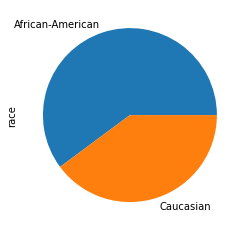

In [95]:
race_counts.plot(kind= 'pie')
